In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

# Approximate q-learning (10 pts)

In this notebook you will teach a __PyTorch__ neural network to do Q-learning.

In [2]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

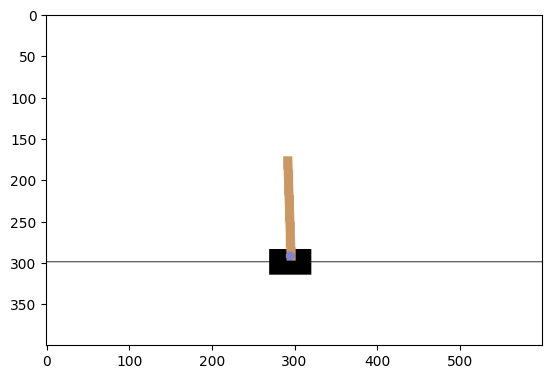

In [3]:
env = gym.make("CartPole-v1", render_mode='rgb_array')
observation, info = env.reset()
n_actions = env.action_space.n
shape_observation = env.observation_space.shape

plt.imshow(env.render())
env.close()

In [4]:
env.observation_space.sample()

array([-3.9132395e+00, -1.4891703e+38,  4.0949574e-01, -4.4201785e+37],
      dtype=float32)

# Approximate Q-learning: building the network

To train a neural network policy one must have a neural network policy. Let's build it.


Since we're working with a pre-extracted features (cart positions, angles and velocities), we don't need a complicated network yet. In fact, let's build something like this for starters:

![img](https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/yet_another_week/_resource/qlearning_scheme.png)

For your first run, please only use linear layers (`nn.Linear`) and activations. Stuff like batch normalization or dropout may ruin everything if used haphazardly. 

Also please avoid using nonlinearities like sigmoid & tanh: since agent's observations are not normalized, sigmoids might be saturated at initialization. Instead, use non-saturating nonlinearities like ReLU.

Ideally you should start small with maybe 1-2 hidden layers with < 200 neurons and then increase network size if agent doesn't beat the target score.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
network = nn.Sequential(nn.Linear(shape_observation[0], 20), 
                        nn.ReLU(),
                        nn.Linear(20, 100),
                        nn.ReLU(),
                        nn.Linear(100, 10),
                        nn.ReLU(),
                        nn.Linear(10, 2))

type(network)

torch.nn.modules.container.Sequential

In [7]:
def get_action(env: gym.Env, network, observation, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    observation = torch.tensor(observation, dtype=torch.float32)
    # print(observation)
    q_values = network(observation)
    # print(q_values)
    if np.random.random() < epsilon:
        return int(np.random.choice(env.action_space.n))
    return int(np.argmax(q_values.detach().numpy()))

# type(get_action(env, network, observation))

In [8]:
s, info = env.reset()
assert tuple(network(torch.tensor([s]*3, dtype=torch.float32)).size()) == (
    3, n_actions), "please make sure your model maps state s -> [Q(s,a0), ..., Q(s, a_last)]"
assert isinstance(list(network.modules(
))[-1], nn.Linear), "please make sure you predict q-values without nonlinearity (ignore if you know what you're doing)"
assert isinstance(get_action(env, network,
    s), int), "get_action(s) must return int, not %s. try int(action)" % (type(get_action(env, network, s)))

# test epsilon-greedy exploration
for eps in [0., 0.1, 0.5, 1.0]:
    state_frequencies = np.bincount(
        [get_action(env, network, s, epsilon=eps) for i in range(10000)], minlength=n_actions)
    best_action = state_frequencies.argmax()
    assert abs(state_frequencies[best_action] -
               10000 * (1 - eps + eps / n_actions)) < 200
    for other_action in range(n_actions):
        if other_action != best_action:
            assert abs(state_frequencies[other_action] -
                       10000 * (eps / n_actions)) < 200
    print('e=%.1f tests passed' % eps)

/var/folders/1t/mmrvr5v56xl32fby2plgg8_c0000gn/T/ipykernel_67390/4193933373.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  assert tuple(network(torch.tensor([s]*3, dtype=torch.float32)).size()) == (


e=0.0 tests passed
e=0.1 tests passed
e=0.5 tests passed
e=1.0 tests passed


### Q-learning via gradient descent

We shall now train our agent's Q-function by minimizing the TD loss:
$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$


Where
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

The tricky part is with  $Q_{-}(s',a')$. From an engineering standpoint, it's the same as $Q_{\theta}$ - the output of your neural network policy. However, when doing gradient descent, __we won't propagate gradients through it__ to make training more stable (see lectures).

To do so, we shall use `x.detach()` function which basically says "consider this thing constant when doingbackprop".

In [24]:
def compute_td_loss(network, states, actions, rewards, next_states, is_done, gamma=0.99, check_shapes=False):
    """ Compute td loss using torch operations only. Use the formula above. """
    states = torch.tensor(
        states, dtype=torch.float32)    # shape: [batch_size, state_size]
    actions = torch.tensor(actions, dtype=torch.long)    # shape: [batch_size]
    rewards = torch.tensor(rewards, dtype=torch.float32)  # shape: [batch_size]
    # shape: [batch_size, state_size]
    next_states = torch.tensor(next_states, dtype=torch.float32)
    is_done = torch.tensor(is_done, dtype=torch.uint8)  # shape: [batch_size]

    # get q-values for all actions in current states
    predicted_qvalues = network(states)

    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[
      range(states.shape[0]), actions
    ]
    # compute q-values for all actions in next states
    predicted_next_qvalues = network(next_states)

    # compute V*(next_states) using predicted next q-values
    next_state_values = torch.amax(predicted_next_qvalues, axis=1)
    assert next_state_values.dtype == torch.float32

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    target_qvalues_for_actions = rewards + gamma * next_state_values

    # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    target_qvalues_for_actions = torch.where(
        is_done, rewards, target_qvalues_for_actions)

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)

    if check_shapes:
        assert predicted_next_qvalues.data.dim(
        ) == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim(
        ) == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim(
        ) == 1, "there's something wrong with target q-values, they must be a vector"

    return loss



In [12]:
# sanity checks
s, info = env.reset()
a = env.action_space.sample()
next_s, r, terminated, truncated, _ = env.step(a)
loss = compute_td_loss([s], [a], [r], [next_s], [terminated or truncated], check_shapes=True)
loss.backward()

assert len(loss.size()) == 0, "you must return scalar loss - mean over batch"
assert np.any(
    next(network.parameters()).grad.detach().numpy() != 0), "loss must be differentiable w.r.t. network weights"


tensor([-0.2211], grad_fn=<IndexBackward0>)


### Playing the game

In [17]:
network.parameters()

<generator object Module.parameters at 0x16ac517e0>

In [18]:
opt = torch.optim.Adam(network.parameters(), lr=1e-4)

In [22]:
def generate_session(env, t_max=1000, epsilon=0, train=False):
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0
    observation, info = env.reset()

    for _ in range(t_max):
        action = get_action(env, network, observation, epsilon=epsilon)
        next_observation, reward, terminated, truncated, info = env.step(action)

        if train:
            opt.zero_grad()
            compute_td_loss(network, [observation], [action], [reward], [next_observation], [terminated or truncated]).backward()
            opt.step()

        total_reward += reward
        observation = next_observation
        if terminated or truncated:
            break

    return total_reward

In [20]:
epsilon = 0.5

In [25]:
for i in range(1000):
    session_rewards = [generate_session(env, epsilon=epsilon, train=True) for _ in range(100)]
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), epsilon))

    epsilon *= 0.99
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"

    if np.mean(session_rewards) > 300:
        print("You Win!")
        break

epoch #0	mean reward = 45.460	epsilon = 0.448
epoch #1	mean reward = 49.070	epsilon = 0.443
epoch #2	mean reward = 51.020	epsilon = 0.439
epoch #3	mean reward = 61.880	epsilon = 0.434
epoch #4	mean reward = 71.330	epsilon = 0.430
epoch #5	mean reward = 80.690	epsilon = 0.426
epoch #6	mean reward = 92.780	epsilon = 0.421
epoch #7	mean reward = 97.070	epsilon = 0.417
epoch #8	mean reward = 99.540	epsilon = 0.413
epoch #9	mean reward = 118.940	epsilon = 0.409
epoch #10	mean reward = 133.570	epsilon = 0.405
epoch #11	mean reward = 163.770	epsilon = 0.401
epoch #12	mean reward = 162.900	epsilon = 0.397
epoch #13	mean reward = 198.530	epsilon = 0.393
epoch #14	mean reward = 218.870	epsilon = 0.389
epoch #15	mean reward = 270.080	epsilon = 0.385
epoch #16	mean reward = 279.710	epsilon = 0.381
epoch #17	mean reward = 299.470	epsilon = 0.377
epoch #18	mean reward = 344.330	epsilon = 0.374
You Win!


: 

### How to interpret results


Welcome to the f.. world of deep f...n reinforcement learning. Don't expect agent's reward to smoothly go up. Hope for it to go increase eventually. If it deems you worthy.

Seriously though,
* __ mean reward__ is the average reward per game. For a correct implementation it may stay low for some 10 epochs, then start growing while oscilating insanely and converges by ~50-100 steps depending on the network architecture. 
* If it never reaches target score by the end of for loop, try increasing the number of hidden neurons or look at the epsilon.
* __ epsilon__ - agent's willingness to explore. If you see that agent's already at < 0.01 epsilon before it's is at least 200, just reset it back to 0.1 - 0.5.

## Итог
### Какая-то простая домашка. 
Агент обучается за 18 итераций

### Глобальные переменные и названия
Мне не нравится использование глобальных переменных в jupyter блокнотах, это очень путает, я переписал немножко. Однобуквенные переменные тоже не нравятся.